# Introdução

O Problema do Caixeiro Viajante "tenta determinar a menor rota para percorrer uma série de cidades (visitando uma única vez cada uma delas), retornando à cidade de origem. Ele é um problema de otimização NP-difícil inspirado na necessidade dos vendedores em realizar entregas em diversos locais (as cidades) percorrendo o menor caminho possível..." (Wikipedia, 2020)

Este notebook almeja ilustrar conceitos de aprendizado de máquina aplicados na otimização dos serviços de uma empresa de segurança patrimonial fictícia, que utiliza drones aéreos para monitoração, cujo problema a ser resolvido é similar ao problema do caixeiro viajante.

O algoritmo utiliza heurística construtiva, do tipo 2-opt, codificado em Python, para determinar a rota otimizada dos vôos dos drones aéreos de monitoração.

Antonio Alisio de Meneses Cordeiro (alisio.meneses@gmail.com)

# Probe Vigilância Inteligente LTDA
---








## Pitch: 

Para organizações com presença municipal, que desejam garantir a segurança do seu patrimônio, a Probe Vigilância Inteligente LTDA (empresa fictícia), sediada no bairro Meireles, em Fortaleza-CE, é uma empresa de vigilância que utiliza drones para monitoraração aérea. Diferente das empresas que operam de maneira estática, com transporte terrestre, a Probe utiliza tecnologia IoT com drones aéreos munidos de múltiplos sensores avançados, algoritmo patenteado PCV™, e inteligência artificial para detectar, localizar e alertar em caso de eventos suspeitos. A Probe utiliza rotas otimizadas e dinâmicas, retornando à base de origem, reduzindo o tempo necessário para o trajeto e os custos com transporte e combustível.

## Problema: 

A empresa Probe foi a vencedora de um processo licitatório aberto pela prefeitura de Fortaleza, cujo objeto de contratação é o serviço de monitoração de parte do patrimônio, composto por prédios localizados em bairros específicos do município de Fortaleza. 

A Probe precisa monitorar os prédios pertencentes à prefeitura de Fortaleza, espalhados em múltiplos bairros da cidade, percorrendo o menor caminho possível, reduzindo o tempo necessário para completar trajeto, os custos inerentes ao transporte e combustível.


In [2]:
import numpy as np

# Calcular a distância no espaço n-dimensional da rota r através dos pontos c, terminando no ponto inicial.
path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])


# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

def two_opt(cities,improvement_threshold): # Função baseada no algoritmo de método heurístico construtivo 2-opt
    route = np.arange(cities.shape[0]) # Fazer um vetor com o número da linha correspondente aos objetos monitorados pelo drone
    improvement_factor = 1 # Inicializar o fator de melhoria
    best_distance = path_distance(route,cities) # Calcular a distância do caminho inicial
    
    while improvement_factor > improvement_threshold: # Se a rota continua melhorando, continue
        distance_to_beat = best_distance # Salvar a distância no começo do loop
        
        for swap_first in range(1,len(route)-2): # From each city except the first and last,
            for swap_last in range(swap_first+1,len(route)): # to each of the cities following,
                new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                
                if new_distance < best_distance: # If the path distance is an improvement,
                    route = new_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
        improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
    return route # When the route is no longer improving substantially, stop searching and return the route.

# **Importar CSV com a latitude e longitude do patrimônio a ser monitorado**

O arquivo CSV com a latitude e longitude em valores decimais pode ser baixado em https://github.com/alisio/probe-tsp/blob/master/bairros-fortaleza-lat-long.csv


In [4]:
from google.colab import files
uploaded = files.upload()


Saving bairros-fortaleza-lat-long.csv to bairros-fortaleza-lat-long.csv


In [5]:
import pandas as pd
cities2= pd.read_csv("bairros-fortaleza-lat-long.csv")
cities2.head(6)


,nome,latitude,longitude
0,meireles,-3.727682,-38.510029
1,aldeota,-3.737513,-38.511218
2,centro,-3.728274,-38.535950
3,Barra do Ceará,-3.704828,-38.589112
4,Dionísio Torres,-3.747552,-38.506480
5,Mucuripe,-3.726926,-38.485426


# Convertendo Longitude e Latitude em coordenadas cartesianas X e Y

**Raio R  do planeta Terra = 6.371 KM**
 
 
 x = R * cos( radiance(lat) ) * cos(radiance (lon))
 
 
 y = R * cos( radiance(lat) ) * sin(radiance (lon))


In [6]:

from math import radians,cos,sin

lat =cities2["latitude"].map(radians)
lon = cities2["longitude"].map(radians)
x = lon.map(cos)*lat.map(cos)*6371
y= lon.map(cos)*lat.map(sin)*6371

cities2["lat_radians"] = lat
cities2["lon_radians"] = lon
cities2["x"] = x
cities2["y"] = y
cities2.head()

,nome,latitude,longitude,lat_radians,lon_radians,x,y
0,meireles,-3.727682,-38.510029,-0.065060,-0.672127,4974.754992,-324.116614
1,aldeota,-3.737513,-38.511218,-0.065232,-0.672148,4974.617143,-324.964862
2,centro,-3.728274,-38.535950,-0.065071,-0.672579,4972.960250,-324.051318
3,Barra do Ceará,-3.704828,-38.589112,-0.064661,-0.673507,4969.415192,-321.778138
4,Dionísio Torres,-3.747552,-38.506480,-0.065407,-0.672065,4974.887460,-325.857875


In [7]:
cities = cities2.drop(["nome","latitude", "longitude", "lat_radians", "lon_radians"], 1)
cities.head(6)

,x,y
0,4974.754992,-324.116614
1,4974.617143,-324.964862
2,4972.960250,-324.051318
3,4969.415192,-321.778138
4,4974.887460,-325.857875
5,4976.458594,-324.161640


In [8]:
df = cities.copy()



In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100), copy=True)
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2'])



In [10]:
cities = np.asarray(cities)


In [11]:
scaled = np.asarray(scaled_df)


In [12]:
# Find a good route with 2-opt ("route" gives the order in which to travel to each city by row number.)
route = two_opt(scaled,0.001)
route

array([ 0,  5,  8,  7, 13,  6,  4, 10, 11, 14,  9, 12,  3,  2,  1])

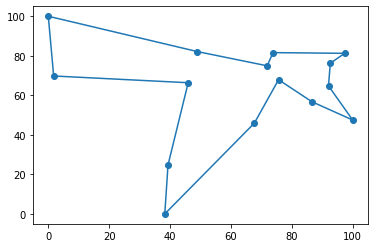

Route: [ 0  5  8  7 13  6  4 10 11 14  9 12  3  2  1]

Distance_scaled: 395.3686197417545


In [13]:
#PLOTAR EM GRÁFICO CARTESIANO


import matplotlib.pyplot as plt
# Reorder the cities matrix by route order in a new matrix for plotting.
new_cities_order = np.concatenate((np.array([scaled[route[i]] for i in range(len(route))]),np.array([scaled[0]])))
# Plot the cities.
plt.scatter(scaled[:,0],scaled[:,1])
# Plot the path.
plt.plot(new_cities_order[:,0],new_cities_order[:,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(route) + "\n\nDistance_scaled: " + str(path_distance(route,scaled)))


In [15]:
# Distância entre latitude máxima e mínima DLA, de acordo com o website 
# Latitude/Longitude Discante Calculator 
# DLA = Lat_conj_palmeiras - Lat_barra_ceara = 16470.88
# DLA = 16.47088 Km
# unidade em escala = 16.47088 /100
# unidade de escala = 0.1647088
# Multiplicar a unidade de escala pelo comprimento da rota
Distance_km = path_distance(route,scaled) * 0.1647088
Distance_km

65.1206909153207

Portanto, a distância total é de 65.1 km

In [16]:
order = pd.DataFrame(route, columns=["index"])
cities2["index"] = cities2.index
cities2
travel=order.merge(cities2, on = "index")




In [17]:

start= travel[0:1]
loop = travel.append(start)
loop


,index,nome,latitude,longitude,lat_radians,lon_radians,x,y
0,0,meireles,-3.727682,-38.510029,-0.065060,-0.672127,4974.754992,-324.116614
1,5,Mucuripe,-3.726926,-38.485426,-0.065047,-0.671697,4976.458594,-324.161640
2,8,Varjota,-3.734490,-38.489766,-0.065179,-0.671773,4976.116043,-324.799085
3,7,Cocó,-3.751233,-38.488998,-0.065471,-0.671760,4976.073995,-326.256648
4,13,Edson Queiroz,-3.775925,-38.478644,-0.065902,-0.671579,4976.647822,-328.448289
5,6,Guararapes,-3.763166,-38.493741,-0.065680,-0.671843,4975.678380,-327.271481
6,4,Dionísio Torres,-3.747552,-38.506480,-0.065407,-0.672065,4974.887460,-325.857875
7,10,Jardim das Oliveiras,-3.780007,-38.512133,-0.065974,-0.672164,4974.311581,-328.650065
8,11,Conjunto Palmeiras,-3.848561,-38.537187,-0.067170,-0.672601,4972.183524,-334.485110
9,14,Passaré,-3.812427,-38.539118,-0.066539,-0.672635,4972.259960,-331.340377


# Plotar Latitude e Longitude

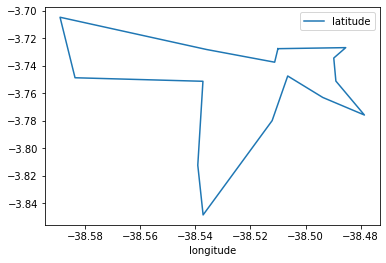

In [18]:
loop.plot(kind="line", x="longitude", y="latitude")

# Exportar arquivo CSV com a rota

In [19]:
# Escrevendo o arquivo CSV com rota

tsp = loop[["latitude", "longitude"]]

tsp.to_csv('probe_rota_pcv.csv', index=False)

from google.colab import files
files.download("probe_rota_pcv.csv")





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

csv disponível em: https://github.com/alisio/probe-tsp/blob/master/probe_rota_pcv.csv

Utilize o arquivo csv contendo latitude e longitude aqui para visualização: http://www.gpsvisualizer.com/draw/ 

# Conclusão

 A rota mais curta de monitoração dos patrimônios indicados pela prefeitura do município de Fortaleza, calculada a partir de algoritmo 2-opt, é de **65.1 km**

A imagem abaixo ilustra a rota mais curta definida pelo algoritmo PCV™, iniciada pela bairro Meireles. 

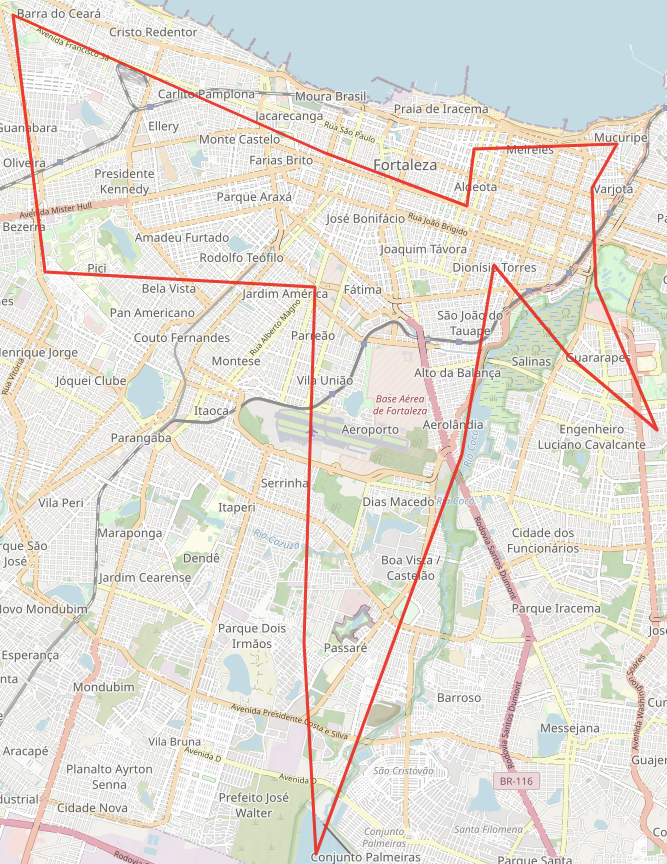

# Referências

GEO MIDPOINT. **Geographic Midpoint Calculation Example**. Disponível em \<http://www.geomidpoint.com/example.html>. Acesso em 17 de agosto de 2020.


IBGE. **IBGE disponibiliza coordenadas e altitudes para 21.304 localidades brasileiras**. Disponível em \<https://agenciadenoticias.ibge.gov.br/agencia-sala-de-imprensa/2013-agencia-de-noticias/releases/14126-asi-ibge-disponibiliza-coordenadas-e-altitudes-para-21304-localidades-brasileiras>. Acesso em 17 de agosto de 2020.

MERIDIANOUTPOST. Latitude/Longitude Distance Calculator. Disponível em <http://www.meridianoutpost.com/resources/etools/calculators/calculator-latitude-longitude-distance.php?>. Acesso em 19 de agosto de 2020.

PRADO, Kelvin. **Github - kelvins/Municipios-Brasileiros**. Disponível em \<https://github.com/kelvins/Municipios-Brasileiros>. Acesso em 17 de agosto de 2020.


TAYLOR, Roy. **Travelling Salesman in scipy**
. Disponível em \<https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy>. Acesso em 17 de agosto de 2020

VIASAT. **Viasat passa a fornecer internet a bordo para aviões da Aeroméxico** .Disponível em \<https://viasatdobrasil.com.br/viasat-passa-a-fornecer-internet-a-bordo-para-avioes-da-aeromexico/>. Acesso em 18 de agosto de 2020

WIKIPEDIA. **2-opt**. Disponível em \<https://en.wikipedia.org/wiki/2-opt>. Acesso em 18 de agosto de 2020.

WIKIPEDIA. **Problema do Caixeiro Viajante**. Disponível em \<https://pt.wikipedia.org/wiki/Problema_do_caixeiro-viajante>. Acesso em 17 de Agosto de 2020.